In [52]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [53]:
class Portfolio:
    def __init__(self, seed, rebalancing=False, rebalancing_month=None):
        self.seed = seed
        self.rebalancing = rebalancing
        self.rebalancing_month = rebalancing_month
        self.holdings = []
        self.market_index = None
        self.df = None
        self.sharpe = None

    # set market index
    def set_market_index(self, Stock):
        self.market_index = Stock
        self.df = pd.DataFrame().reindex_like(Stock.df)

    def set_period(self):
        print("입력 시작 기간 :", self.market_index.df.reset_index()["Date"][0])

        min_length = min([stock.df.shape[0] for stock in self.holdings])

        self.market_index.df = self.market_index.df[-min_length:]
        self.market_index.df.reset_index(inplace=True)
        self.df = self.df[-min_length:]
        self.df.reset_index(inplace=True)
        for stock in self.holdings:
            stock.df = stock.df[-min_length:]
            stock.df.reset_index(inplace=True)

        min_length_ticker = self.holdings[[stock.df.shape[0] for stock in self.holdings].index(min_length)].name
        print("최소 기간 종목 :", min_length_ticker)
        print("백테스트 시작일 :", self.holdings[0].df.reset_index()["Date"][0])

    def add_stock(self, Stock):
        self.holdings.append(Stock)

    def run_backtest(self):
        self.df["seed"] = 0
        self.df["rebalancing"] = 0
        last_rebalanced_month = 0

        # 개별 자산 변동률, 시드 변동 계산
        for stock in (self.holdings + [self.market_index]):
            stock.df["change"] = stock.df["Adj Close"].pct_change()+1
            stock.df["seed"] = self.seed*stock.ratio

        # 주가 변화 계산
        for i in tqdm(range(1, len(self.market_index.df))):
            for stock in (self.holdings + [self.market_index]):
                stock.df.at[i, "seed"] = stock.df.at[i-1, "seed"]*stock.df.at[i, "change"]

            # 리밸런싱. 연 1회 리밸런싱은 코드 수정해야함
            # 매 달의 1일이 공휴일인 경우도 있으므로 최대 4일까지 고려
            if self.rebalancing and (self.market_index.df.at[i, "Date"].month in self.rebalancing_month) and (self.market_index.df.at[i, "Date"].day in [1, 2, 3, 4]):
                # 리밸런싱된 월이 이번달이 아닐 때
                if last_rebalanced_month != self.market_index.df.at[i, "Date"].month:
                    last_rebalanced_month = self.market_index.df.at[i, "Date"].month
                    seed_sum = 0
                    for stock in self.holdings:
                        seed_sum += stock.df["seed"][i]*0.9975  # 매매 수수료 적용
                    for stock in self.holdings:
                        stock.df["seed"][i] = seed_sum*stock.ratio
                        self.df["rebalancing"][i] = 1

        # 개별주식을 포트폴리오로 종합
        for stock in self.holdings:
            self.df["seed"] += stock.df["seed"]

        # MDD 계산
        self.market_index.df["recent_high"] = self.market_index.df["Adj Close"].cummax()
        self.market_index.df["dd"] = (1 - self.market_index.df["Adj Close"]/self.market_index.df["recent_high"]) * 100
        self.df["recent_high"] = self.df["seed"].cummax()
        self.df["dd"] = (1 - self.df["seed"]/self.df["recent_high"]) * 100
        for stock in (self.holdings + [self.market_index]):
            stock.df["recent_high"] = stock.df["seed"].cummax()
            stock.df["dd"] = (1 - stock.df["seed"]/stock.df["recent_high"]) * 100

        # 시장지수 대비 샤프지수 계산
        self.market_index.df["returns"] = (self.market_index.df["Adj Close"] - self.market_index.df["Adj Close"][0]) / self.market_index.df["Adj Close"][0]
        for stock in self.holdings:
            stock.df["returns"] = (stock.df["Adj Close"] - stock.df["Adj Close"][0]) / stock.df["Adj Close"][0]
            std = stock.df["returns"].std()
            sharpe = (stock.df["returns"]- self.market_index.df["returns"])/std
            stock.sharpe = sharpe.mean()
        self.df["returns"] = (self.df["seed"] - self.df["seed"][0]) / self.df["seed"][0]
        std = self.df["returns"].std()
        sharpe = (self.df["returns"]- self.market_index.df["returns"])/std
        self.sharpe = sharpe.mean()

    def print_result(self):
        for stock in self.holdings:
            print(f"종목명 : {stock.name}")
            total_yield = stock.df.iloc[-1]["seed"]/stock.df["seed"][0]
            print(f"최종금액 : {int(stock.df.iloc[-1]['seed'])}원")
            print(f"총 수익률 : {round((total_yield-1)*100, 2)}%")
            print(f"연평균 수익률 : {round((total_yield ** (1/(len(self.market_index.df)/365))-1) * 100, 2)}%")
            print(f"최대 낙폭(MDD) : {round(stock.df['dd'].max(), 2)}%")
            print(f"샤프지수 : {round(stock.sharpe, 2)}\n")

        print("포트폴리오 결과")
        portfolio_yield = self.df.iloc[-1]['seed']/self.seed
        print(f"최종금액 : {int(self.df.iloc[-1]['seed'])}원")
        print(f"총 수익률 : {round(portfolio_yield*100, 2)}%")
        print(f"연평균 수익률 : {round((portfolio_yield ** (1/(len(self.market_index.df)/365))-1) * 100, 2)}%")
        print(f"최대 낙폭(MDD) : {round(self.df['dd'].max(), 2)}%")
        print(f"샤프지수 : {round(self.sharpe, 2)}\n")

        market_yield = self.market_index.df.iloc[-1]['seed']/self.seed
        print(f"포트폴리오의 최초 금액은 {self.seed}원, 최종 금액은 {int(self.df.iloc[-1]['seed'])}원으로 최종 수익률은 {round((portfolio_yield-1)*100, 2)}% 입니다.\n"
              f"같은 기간 동안 시장의 수익률은 {round((market_yield-1)*100, 2)}%로 시장{'을 이겼습니다.' if portfolio_yield>market_yield else '에 졌습니다.'}\n"
              f"최대 낙폭은 {round(self.df['dd'].max(), 2)}로 같은 기간 시장 최대 낙폭 {round(self.market_index.df['dd'].max(), 2)}보다 더 {'높아 위험합니다.' if self.df['dd'].max() > self.market_index.df['dd'].max() else '낮아 안정적입니다.'}")

class Stock:
    def __init__(self, name, ratio, df):
        self.name = name
        self.ratio = ratio
        self.df = df
        self.length = len(df)
        self.sharpe = None

In [54]:
tickers = ["QLD", "QQQ", "SSO", "VOO", "SCHD", "O", "XLU", "LTPZ"]
exposure_ratio = [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.1, 0.1]  # 차등분배
#exposure_ratio = [1/len(portfolio)]*len(portfolio)  # 균등분배
portfolio_seed = 100000
backtest_years = 5
rebalancing = True
rebalancing_month = [1, 4, 7, 10]
#rebalancing_month = [i for i in range(1, 13)]
start_day = datetime.datetime.now()-datetime.timedelta(days=int(365*backtest_years))

market_index_df = pdr.get_data_yahoo("^GSPC", start_day)  # S&P 500
market_index_stock = Stock("S&P500", 1, market_index_df)

portfolio = Portfolio(portfolio_seed, rebalancing, rebalancing_month)
portfolio.set_market_index(market_index_stock)

for i, ticker in enumerate(tickers):
    df = pdr.get_data_yahoo(ticker, start_day)
    stock = Stock(ticker, exposure_ratio[i], df)
    portfolio.add_stock(stock)

portfolio.set_period()
portfolio.run_backtest()
portfolio.print_result()

입력 시작 기간 : 2017-08-29 00:00:00
최소 기간 종목 : QLD
백테스트 시작일 : 2017-08-29 00:00:00


100%|██████████| 1257/1257 [00:00<00:00, 3975.21it/s]

종목명 : QLD
최종금액 : 21287원
총 수익률 : 112.88%
연평균 수익률 : 24.51%
최대 낙폭(MDD) : 54.0%
샤프지수 : 0.87

종목명 : QQQ
최종금액 : 19876원
총 수익률 : 98.76%
연평균 수익률 : 22.06%
최대 낙폭(MDD) : 31.63%
샤프지수 : 0.66

종목명 : SSO
최종금액 : 20384원
총 수익률 : 103.84%
연평균 수익률 : 22.95%
최대 낙폭(MDD) : 60.71%
샤프지수 : 0.62

종목명 : VOO
최종금액 : 19388원
총 수익률 : 93.88%
연평균 수익률 : 21.18%
최대 낙폭(MDD) : 33.99%
샤프지수 : 0.22

종목명 : SCHD
최종금액 : 37540원
총 수익률 : 87.7%
연평균 수익률 : 20.05%
최대 낙폭(MDD) : 33.37%
샤프지수 : 0.19

종목명 : O
최종금액 : 36477원
총 수익률 : 82.39%
연평균 수익률 : 19.05%
최대 낙폭(MDD) : 48.28%
샤프지수 : -0.48

종목명 : XLU
최종금액 : 19219원
총 수익률 : 92.2%
연평균 수익률 : 20.87%
최대 낙폭(MDD) : 36.07%
샤프지수 : -0.88

종목명 : LTPZ
최종금액 : 18768원
총 수익률 : 87.69%
연평균 수익률 : 20.04%
최대 낙폭(MDD) : 35.4%
샤프지수 : -0.91

포트폴리오 결과
최종금액 : 192943원
총 수익률 : 192.94%
연평균 수익률 : 21.01%
최대 낙폭(MDD) : 36.51%
샤프지수 : 0.35

포트폴리오의 최초 금액은 100000원, 최종 금액은 192943원으로 최종 수익률은 92.94% 입니다.
같은 기간 동안 시장의 수익률은 65.87%로 시장을 이겼습니다.
최대 낙폭은 36.51로 같은 기간 시장 최대 낙폭 33.92보다 더 높아 위험합니다.


In [55]:
portfolio.holdings[0].df

,Date,High,Low,Open,Close,Volume,Adj Close,change,seed,recent_high,dd,returns
0,2017-08-29,15.542500,15.075000,15.110000,15.490000,3932400.0,15.453973,NaN,10000.000000,10000.000000,0.000000,0.000000
1,2017-08-30,15.900000,15.497500,15.520000,15.860000,6350400.0,15.823112,1.023886,10238.863315,10238.863315,0.000000,0.023886
2,2017-08-31,16.192499,15.925000,15.937500,16.155001,5297200.0,16.117428,1.018600,10429.310325,10429.310325,0.000000,0.042931
3,2017-09-01,16.277500,16.062500,16.235001,16.152500,3979600.0,16.114931,0.999845,10427.694741,10429.310325,0.015491,0.042769
4,2017-09-05,16.117500,15.617500,16.040001,15.855000,8012400.0,15.818123,0.981582,10235.635232,10429.310325,1.857027,0.023564
...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2022-08-22,52.799999,51.049999,52.720001,51.349998,6863400.0,51.349998,0.947067,22326.824120,25216.912303,11.460912,2.322770
1254,2022-08-23,52.189999,50.990002,51.250000,51.259998,3306000.0,51.259998,0.998247,22287.692326,25216.912303,11.616093,2.316946
1255,2022-08-24,52.150002,50.889999,51.080002,51.549999,2665900.0,51.549999,1.005657,22413.783848,25216.912303,11.116065,2.335712
1256,2022-08-25,53.349998,51.770000,52.119999,53.340000,3793600.0,53.340000,1.034724,23192.070835,25216.912303,8.029696,2.451540


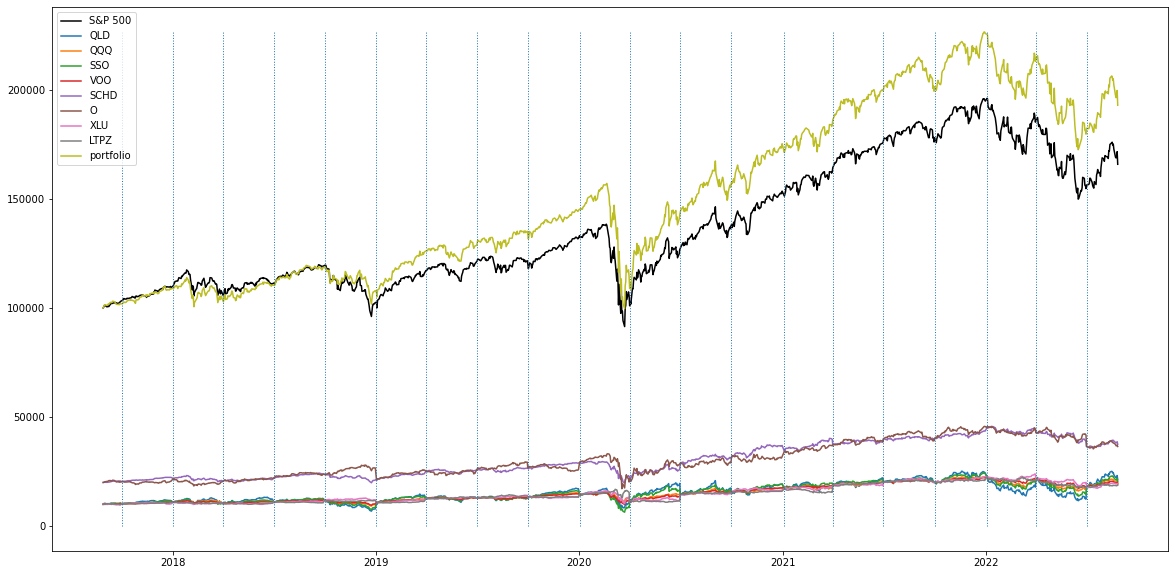

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(portfolio.market_index.df.set_index("Date")["seed"], label="S&P 500", color="black")
for stock in portfolio.holdings:
    plt.plot(stock.df.set_index("Date")["seed"], label=stock.name)

portfolio_df = portfolio.df.set_index("Date")
plt.plot(portfolio_df["seed"], label="portfolio")
plt.vlines(portfolio_df[portfolio_df["rebalancing"]==1].index, ymin=0, ymax=portfolio_df["seed"].max(), linewidth=1, linestyles="dotted")
plt.legend()